* [WA_Fn-UseC_-HR-Employee-Attrition.csv] : https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

#Part5. [실습3] HR 데이터를 활용한 직원 이탈 요인 분석

## 01. 데이터 소개 및 분석프로세스 수립
 : "강의자료 → Ch05. [실습3] HR 데이터를 활용한 직원 이탈 요인 분석" 참고

## 02. 데이터 준비를 위한 EDA 및 전처리

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm

path = '/Users/brianna/Downloads/nanum-gothic-eco/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

plt.rc('font', family=font_name)

fm._rebuild()

In [ ]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [ ]:
pip uninstall scikit-learn

In [ ]:
Y

### 0. 데이터 불러오기

In [ ]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE # 데이터 불균형 해결 패키지
import xgboost

from scipy.stats import pearsonr, chi2_contingency # 상관성 분석
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
attrition = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch3/WA_Fn-UseC_-HR-Employee-Attrition.csv')
attrition.head()

In [ ]:
# 데이터의 모양 알아보기
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######

### 1. 데이터 탐색

#### 1) 변수 간 관계 시각화

##### KDE Plot

In [ ]:
# 여러 개의 KDE Plot 생성 준비
f, axes = plt.subplots(3, 3, figsize=(10, 8), 
                       sharex=False, sharey=False)

# Plot 색상 설정
s = np.linspace(0, 3, 10)
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)

x = attrition['Age'].values
y = attrition['TotalWorkingYears'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=axes[0,0])
axes[0,0].set( title = '총 근로 기간 - 나이')

cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)

# Generate and plot
x = attrition['Age'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set( title = '일일 급여 수준 - 나이')

cmap = sns.cubehelix_palette(start=0.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsInCurrentRole'].values
y = attrition['Age'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,2])
axes[0,2].set( title = '직무 기간 - 나이')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,0])
axes[1,0].set( title = '일일 급여 수준 - 출퇴근 거리')

cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,1])
axes[1,1].set( title = '일일 급여 수준 - 직무만 족도')

cmap = sns.cubehelix_palette(start=1.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,2])
axes[1,2].set( title = '근속 연수 - 직무 만족도')

cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,0])
axes[2,0].set( title = '근속 연수 - 일일 급여 수준')

cmap = sns.cubehelix_palette(start=2.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,1])
axes[2,1].set( title = '관계 만족도 - 관리자와의 협업 기간')

cmap = sns.cubehelix_palette(start=2.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,2])
axes[2,2].set( title = '일과 삶의 균형 - 만족도')

f.tight_layout()

### 2. 데이터 전처리
  * 결측값 처리
  * 중복값 처리

#### 1) 결측값 처리

In [ ]:
# Looking for NaN
display(attrition.isnull().any())

#### 2) 중복값 처리

In [ ]:
# 중복된 항목 수 알아보기
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######

### 3. Target Feature 정의
* 방법1 : Pandas 의 apply 이용
* 방법2 : y.isin([Target에 해당하는 컬럼들]).astype('int') 이용

In [ ]:
# 퇴직 여부(Yes/No)에 따라 각각 1, 0 으로 할당
target_map = {'Yes':1, 'No':0}

# pandas apply 를 이용하여 퇴직 여부를 1, 0 으로 표시한 새로운 컬럼 생성
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######
attrition["Attrition_numerical"].value_counts()

In [ ]:
y = attrition['Attrition'].copy()
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######
y.value_counts()

### 4. 데이터 타입별 Feature 변환

#### 1) Feature 탐색

##### 총 Feature 개수 확인

In [ ]:
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######

##### Feature 데이터 타입별 개수 확인

In [ ]:
# 데이터 타입별 컬럼 수 확인
dtype_data = attrition.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"]
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

#### 2) 범주형 Feature
  * 데이터 확인
  * Feature 별 개수 시각화
  * 날짜/숫자/기간 등으로 변환해야 할 항목이 있는지 확인
  * Feature 별 개수 시각화
  * Feature 의 개수가 인코딩에 적합한가?

##### 데이터 확인

In [ ]:
# pandas 의 select_dtypes 사용하여 범주형 데이터만 확인하기
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######

##### Feature 제거

> Feature 별 유일한 값 개수 확인

In [ ]:
cat_feat = attrition.select_dtypes('object','category').columns.values
attrition_cat = attrition[cat_feat].copy()
print(attrition_cat.nunique().sort_values())

> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다
* Target Feature 가 포함되어 있으면 함께 제거

In [ ]:
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######

##### Feature 별 개수 시각화

In [ ]:
for col in attrition_cat.columns:
  fig = sns.catplot(x=col, kind="count", data=attrition_cat, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

##### Feature 의 개수가 인코딩에 적합한가?
  * 인코딩을 했을 경우 메모리 문제가 발생하지는 않는가?

> Feature 인코딩
* LabelEncoder : LabelEncoder 는 선형성을 가지는 머신러닝 기법에 쓰면 좋지 않다
* OneHotEncoder vs. get_dummies

In [ ]:
attrition_cat_dummies = pd.get_dummies(attrition_cat)
attrition_cat_dummies.head(3)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

###### 코드 작성 부분 시작 ######
# ohe = 
# attrition_cat_ohe = 
###### 코드 작성 부분 마침 ######
attrition_cat_ohe = pd.DataFrame(attrition_cat_ohe)
attrition_cat_ohe.columns = ['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'OverTime_No', 'OverTime_Yes']

print("OneHot Encoder 결과 : ")  
print(attrition_cat_ohe.iloc[:,:2])

#### 3) 숫자형 Feature
  * 데이터 확인
  * Feature 제거
  * Feature Skewness 확인

##### 데이터 확인

In [ ]:
# pandas 의 select_dtypes('object') 사용
attrition.select_dtypes(include=['number']).head()

In [ ]:
attrition.select_dtypes(include=np.number).head()

In [ ]:
num_feat = attrition.select_dtypes('number').columns.values
attrition_num = attrition[num_feat].copy()

##### Feature 제거

> Feature 별 유일한 값 개수 확인

In [ ]:
print(attrition_num.nunique().sort_values())

In [ ]:
print(attrition.shape)

> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다
* Target Feature 가 포함되어 있으면 함께 제거

In [ ]:
attrition_num = attrition_num.drop(['StandardHours','EmployeeCount','EmployeeNumber','Attrition_numerical'], axis=1, errors='ignore')

##### Feature Skewness 확인

In [ ]:
col_attrition_num = attrition_num.columns.values
for i in range(0,len(col_attrition_num)):
    sns.displot(attrition_num[col_attrition_num[i]],kde=True) # kde : kernel density

### 5. 상관성에 따른 Feature 정제

#### 1) 숫자형 Feature
  * 데이터 확인
  * 숫자형 컬럼들 간 Pearson R 상관 계수를 구한다
  * 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼을 제거해 본다
  * 컬럼들 간 조합 생성 : comb_num_feat = np.array(list(combinations(num_feat, 2)))
  * Pearson R 상관 계수 구하기 : pearsonr(x1, x2)[0]

##### 데이터 확인

In [ ]:
attrition_num.nunique().sort_values()

##### Feature 간 관계 시각화

In [ ]:
# Refining our list of numerical variables
numerical = [u'Age', u'DailyRate',  u'JobSatisfaction',
       u'MonthlyIncome', u'PerformanceRating',
        u'WorkLifeBalance', u'YearsAtCompany', u'Attrition_numerical']

g = sns.pairplot(attrition[numerical], hue='Attrition_numerical', palette='seismic', diag_kind = 'kde',diag_kws=dict(shade=True))
g.set(xticklabels=[])

##### 상관계수 구하기

* 방법 1

In [ ]:
num_feat = attrition_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(attrition_num[comb[0]], attrition_num[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [ ]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

* 방법 2

In [ ]:
# plotly 안 보이는 문제 해결
import plotly.io as pio
pio.renderers.default = 'colab'
pio.renderers

data = [
    go.Heatmap(
        z=attrition_num.astype(float).corr().values, # 피어슨 상관계수
        x=attrition_num.columns.values,
        y=attrition_num.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0
        
    )
]


layout = go.Layout(
    title='숫자형 Feature 들의 피어슨 상관계수',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')



##### Feature 제거

In [ ]:
attrition_num = attrition_num.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

#### 2) 범주형 Feature
  * 데이터 확인

##### 데이터 확인

In [ ]:
attrition_cat_dummies.nunique().sort_values()

In [ ]:
attrition_cat_dummies.head()

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [ ]:
rows= []

for var1 in attrition_cat_dummies:
  col = []
  for var2 in attrition_cat_dummies :
    cramers =cramers_V(attrition_cat_dummies[var1], attrition_cat_dummies[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = attrition_cat_dummies.columns, index =attrition_cat_dummies.columns)

df.head()

In [ ]:
high_corr_num = comb_cat_dummies_feat[np.abs(corr_cat_dummies_feat) >= 0.9]
high_corr_num

In [ ]:
# Concat the two dataframes together columnwise
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######

In [ ]:
attrition_final.head()

### 6. Target Feature 불균형 문제 처리

#### 1) 불균형 데이터 확인

In [ ]:
data = [go.Bar(
            x=attrition["Attrition"].value_counts().index.values,
            y= attrition["Attrition"].value_counts().values
    )]

py.iplot(data, filename='basic-bar')

#### 2) SMOTE 를 이용한 오버샘플링 적용

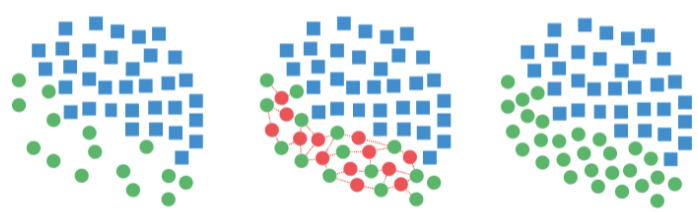

In [ ]:
target = attrition["Attrition_numerical"]

In [ ]:
# Import the train_test_split method
from sklearn.model_selection import train_test_split

# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_val = train_test_split(attrition_final, 
                                                         target, 
                                                         train_size= 0.80,
                                                         random_state=0);


In [ ]:
###### 코드 작성 부분 시작 ######
# oversampler = 
# smote_train, smote_target =
###### 코드 작성 부분 마침 ######

## 03. 머신러닝 모델링

#### 1) 분석 목표는 '직원 이탈의 주요한 원인(Feature)'

#### 2) RandomForest 분류 모델

##### GridSearchCV 를 이용한 최적 Hyper Parameter 탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_params = { 'n_estimators' : [10, 100],
           'max_depth' : [4, 8, 10, 12],
           'min_samples_leaf' : [2, 4, 8, 12],
           'max_features' : [0.1, 0.3, 0.5]
            }

# RandomForest Classifier 객체 생성 후 GridSearchCV 수행
###### 코드 작성 부분 시작 ######
# rf_clf =
# grid_cv = 
###### 코드 작성 부분 마침 ######
grid_cv.fit(smote_train, smote_target)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [ ]:
seed = 0
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    ###### 코드 작성 부분 시작 ######

    ###### 코드 작성 부분 마침 ######
    'random_state' : seed,
    'verbose': 0
}

In [ ]:
rf = RandomForestClassifier(**rf_params)

##### 모델 성능

In [ ]:
rf.fit(smote_train, smote_target)
rf_predictions = rf.predict(test)
print("Accuracy score: {}".format(accuracy_score(target_val, rf_predictions)))
print("="*60)
print(classification_report(target_val, rf_predictions))

#### 3) Gradient Boosting 분류 모델

##### GridSearchCV 를 이용한 최적 Hyper Parameter 탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

gb_params = { 'n_estimators' : [1000, 1500],
           'max_depth' : [4, 6],
           'min_samples_leaf' : [2, 4],
           'max_features' : [0.7, 0.9],
           'learning_rate' : [0.25,0.3]
            }

# RandomForest Classifier 객체 생성 후 GridSearchCV 수행
###### 코드 작성 부분 시작 ######
# random_state = 0
# gb_clf = 

# param_grid = gb_params, cv = 3, n_jobs = -1
# grid_cv = 
###### 코드 작성 부분 마침 ######
grid_cv.fit(smote_train, smote_target)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [ ]:
# Gradient Boosting Parameters
seed = 0
gb_params ={
    ##### 코드 작성 #####
    'random_state' : seed,
    'verbose': 0
}

In [ ]:
gb = GradientBoostingClassifier(**gb_params)
gb.fit(smote_train, smote_target)
gb_predictions = gb.predict(test)

##### 모델 성능

In [ ]:
print("Accuracy score: {}".format(accuracy_score(target_val, gb_predictions)))
print(classification_report(target_val, gb_predictions))

## 04. Feature Importances

#### 1) Random Forest 모델

In [ ]:

trace = go.Scatter(
    ###### 코드 작성 부분 시작 ######
    # y = 
    ###### 코드 작성 부분 마침 ######
    x = attrition_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = attrition_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [ ]:
feat = attrition_final.columns.values
imp = rf.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

#### 2) Gradient Boosting 모델

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = attrition_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = attrition_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')

In [ ]:
feat = attrition_final.columns.values
imp = gb.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);